# MCMC

*Davide Gerosa (Milano-Bicocca)*

This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.


A few nice things:
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.
- [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068) by Hogg and Foreman-Mackey

---


## Markov Chain Monte Carlo (MCMC) Techniques <a class="anchor" id="two"></a>

> The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***.

Given such a Markov chain of length $N$ that corresponds to draws of $p(\theta)$, integrals can be estimated as

$$ \int g(\theta) \, p(\theta) \, d\theta \approx {1 \over N} \sum_{i=1}^Ng(\theta_i).$$

- To estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$), we simply take the mean value of all $\theta_1$ in the chain.
- To visualize the posterior pdf for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$, we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1.
- To get a MAP (*maximum a posterori*) estimate for $\theta_1$, we find the maximum of this marginalized pdf.

In order for a Markov chain to reach a **stationary distribution** proportional to $p(\theta)$, the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,

$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$

where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the **proposal distribution** (and it is assumed that we know how to compute $p(\theta_i)$). The proposal distribution is exactly what it sounds like-- it proposes new positions to jump to in parameter space.

This requirement will be satisfied when the transition probability satisfies **the principle of detailed balance**

$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$

Most of the difficulty in MCMC comes from either determining the burn-in or deciding how to step from one position to another.  In our $\pi$ circle example above, we drew points in a completely random manner. However, that's sub-optimal. ***We want random sampling that preferentially steps into regions of high probability density.***  

The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  

## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$

where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. A Gaussian distribution centered on the current point $\theta_i$ is often used for $T(\theta_{i+1}|\theta_i)$.

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$!

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$.
4. ***If $\theta_{i+1}$ is accepted added it to the chain. If not, add $\theta_{i}$ to the chain.***
5. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements).

***Step 4*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

### Corner Plots

If you are using MCMC, then you probably have multiple parameters (otherwise, you'd be doing something easier).  So, it helps to display the parameters two at a time, marginalizing over the other parameters.  An example is given in Ivezic, Figure 5.24, which compares the model results for a single Gaussian fit to a double Gaussian fit. These are called `corner` or `triangle` plots, which we've discussed before.

The most popular packages to make these are [corner](https://corner.readthedocs.io/en/latest/) and [chainconsumer](https://samreay.github.io/ChainConsumer/) (I used [scotchcorner](https://github.com/mattpitkin/scotchcorner) which was great, but it looks like it's not maintained anymore).

![Screen%20Shot%202022-03-22%20at%2018.43.25.png](attachment:Screen%20Shot%202022-03-22%20at%2018.43.25.png)

[(Ashton et al 2018)](https://arxiv.org/abs/1811.02042)

## Worked Example <a class="anchor" id="four"></a>

Let's now go through the worked example from
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

Let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points, using [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html). Our goal is to estimate $\mu$.

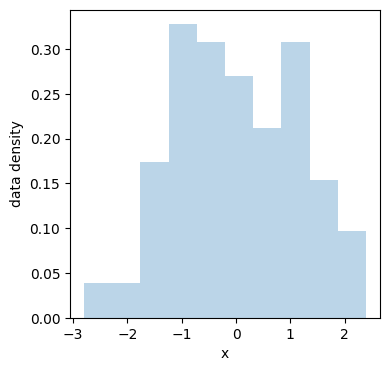

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import pylab as plt
from scipy.stats import norm

np.random.seed(123)

data = np.random.randn(100)
plt.figure(figsize=(4,4))
plt.hist(data, bins=10, density=True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('data density');

In [2]:
data

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ,
        0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
       -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ,
       -0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
       -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732,
       -0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
       -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334,
       -1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
        1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267,
       -0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
        0.80723653,  0.04549008, -0.23309206, -1.19830114,  0.19

Now we have to pick a model.

- We'll assume a Gaussian likelihood distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  
- We'll also assume a Gaussian distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write an analytic function for our posterior distribution as follows (*recalling that the product of two Gaussians is also a Gaussian*):

Text(0, 0.5, 'post probability density')

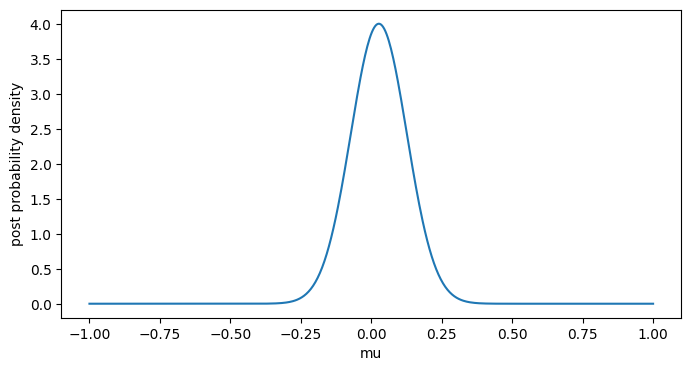

In [3]:
# Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)

    # Error-weighted sum of prior and average of data
    # Recall the product of 2 Gaussians

    # This is the Gaussian for the prior: mu_0 / sigma_0**2
    # This is the Gaussian for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values

    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1

    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,4))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post probability density')

Let's try this instead with MCMC.

- We'll start with a trial $\mu_0 = -1$ and evaluate.
- Then we'll jump to a new position using the Metropolis-Hastings algorithm mentioned above.  
- Next we evaluate whether that jump was "good" or not -- by seeing if the value of the likelihood $\times$ prior increases.  

*We always work with the un-normalized posterior (i.e. likelihood $\times$ prior) in these MCMC algorithms (or equivalently the un-normalized log-posterior which equals log-likelihood + log-prior).*

The first function below is an implementation of the Metropolis-Hastings algorithm

In [4]:
## Execute this cell
## See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5,
            plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        # Compute prior probability of current and proposed mu
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept > 1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu,
                          mu_prior_sd, data, accept, posterior, i)

        if accept:
            # Update position
            mu_current = mu_proposal

        posterior.append(mu_current)

    return posterior

## Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu,
                  mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'

    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density',
            title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current,
                                                                                       prior_current,
                                                                                       mu_proposal,
                                                                                       prior_proposal))

    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)

    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')

    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current,
                                                                              1e14*likelihood_current,
                                                                              mu_proposal,
                                                                              1e14*likelihood_proposal))

    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid,
                                                     mu_prior_mu,
                                                     mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current,
                                                  mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal,
                                                   mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))

    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current,
                                                                            posterior_current,
                                                                            mu_proposal,
                                                                            posterior_proposal))
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

Each row is a single iteration through our Metropolis-Hastings sampler.

- **1st column = prior distribution**. The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).


- **2nd column = likelihood**.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed mu. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current mu.


- **3rd column = (normalized) posterior distribution**.


- **4th column = trace** (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values

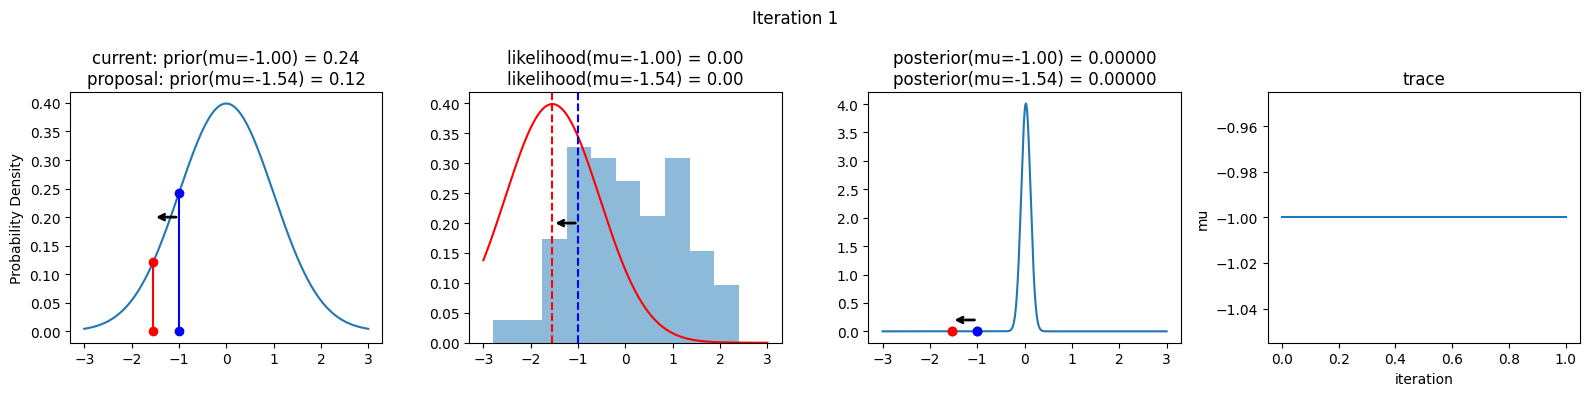

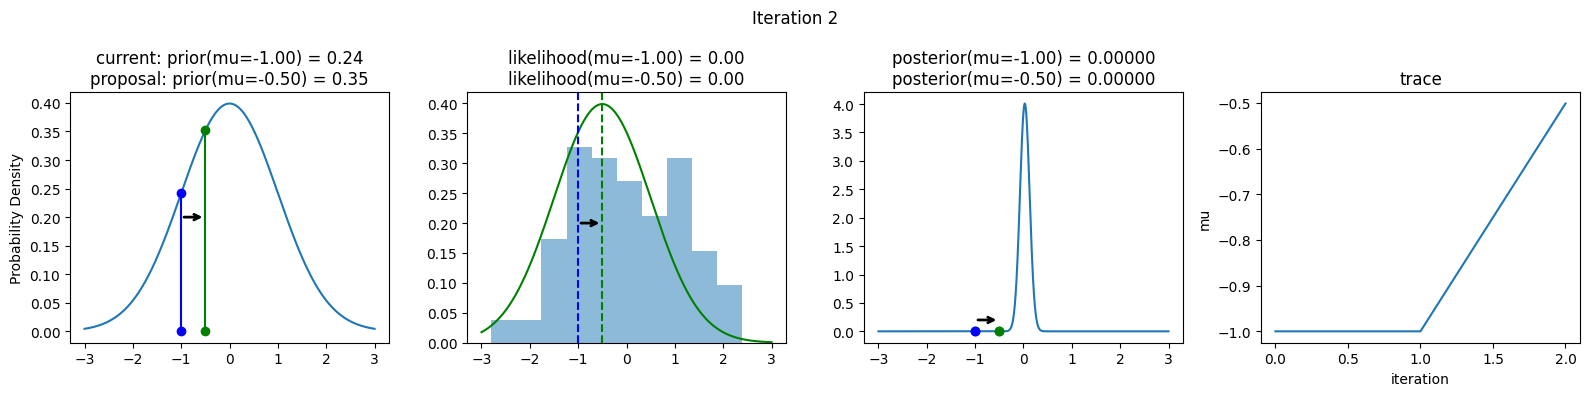

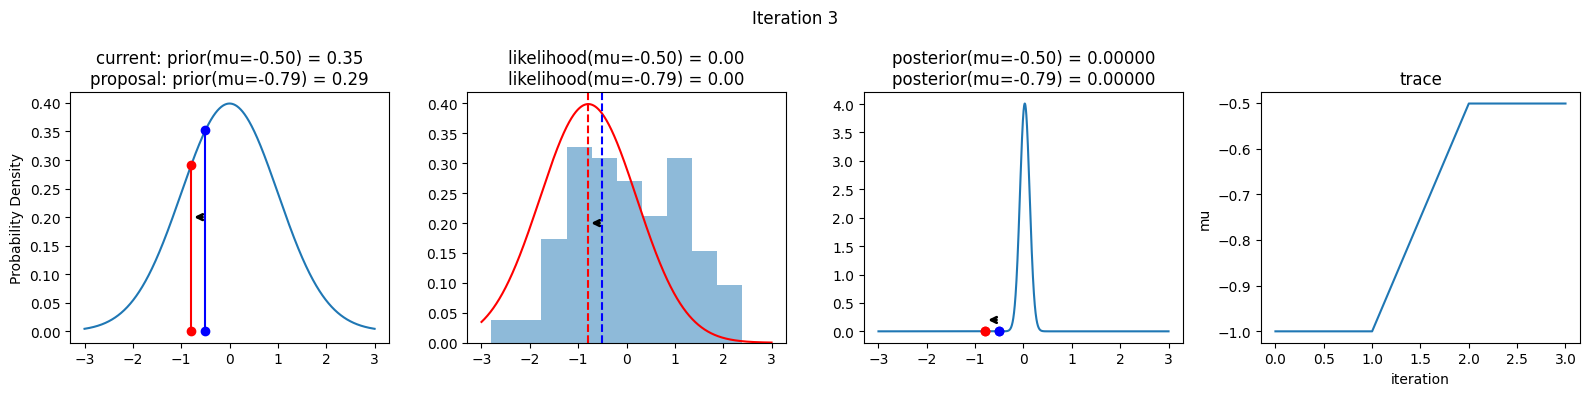

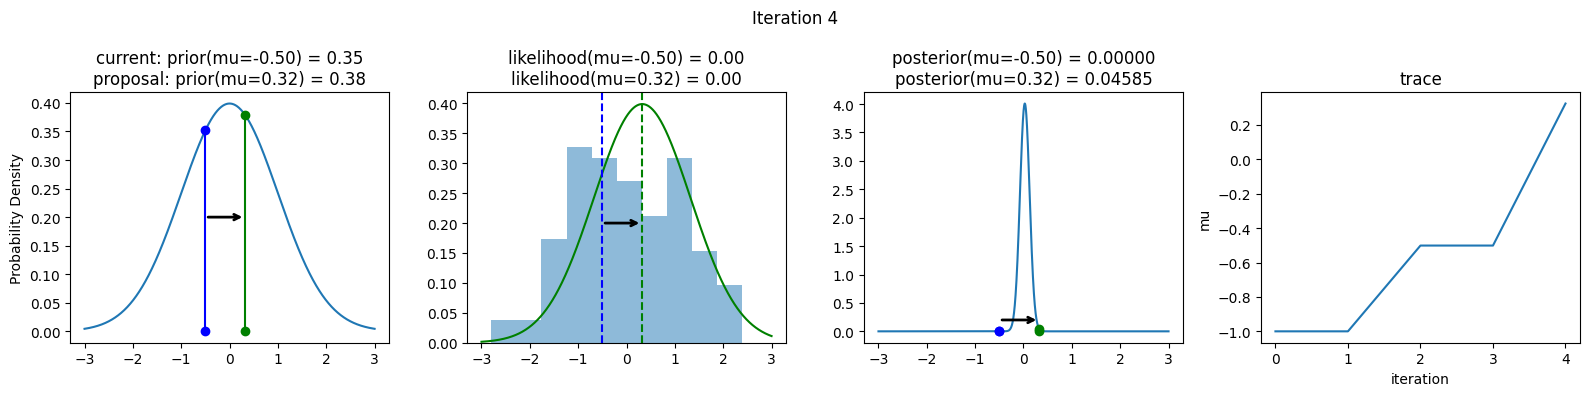

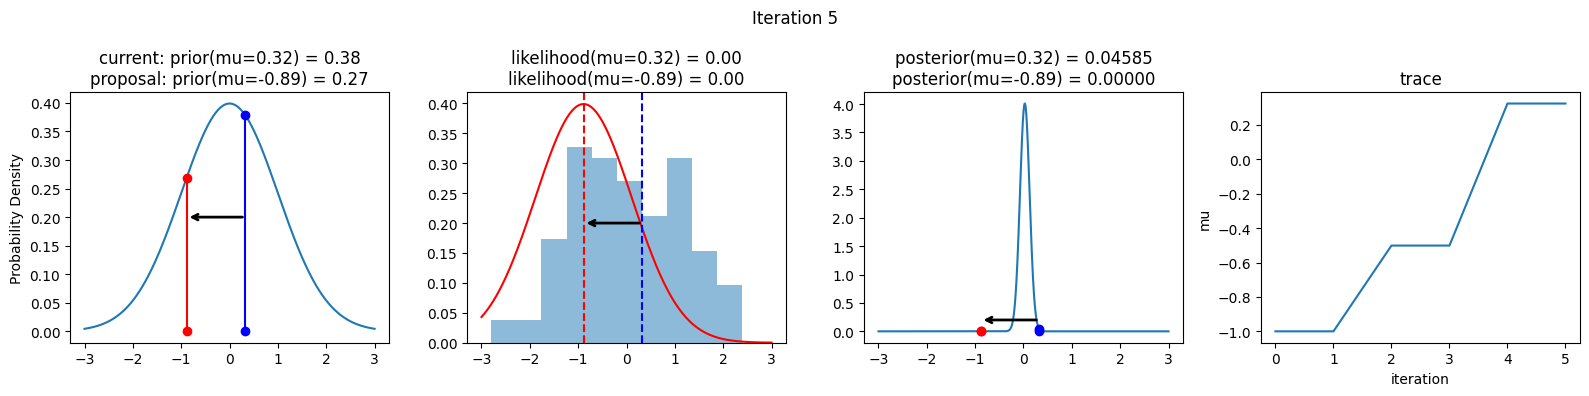

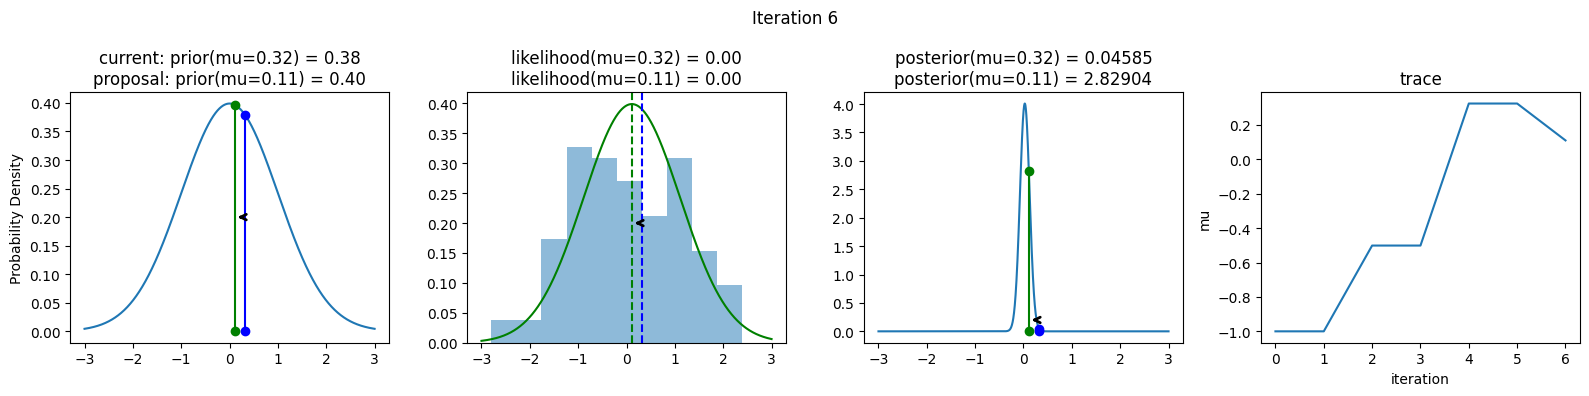

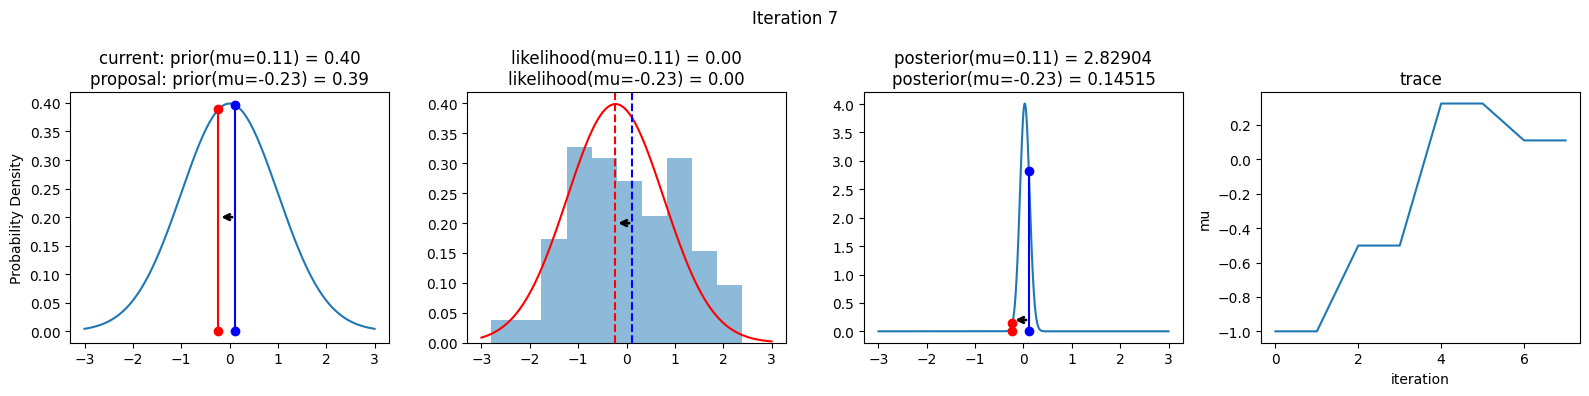

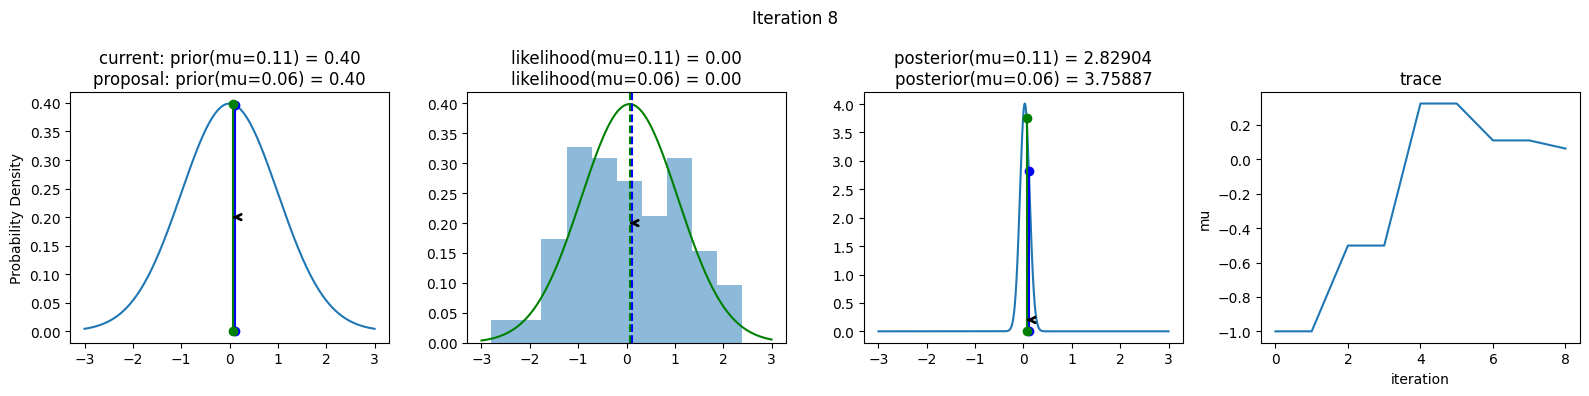

In [5]:
np.random.seed(123)
samples = sampler(data, samples=8, mu_init=-1., plot=True);

What happens when we do this lots of times? You might need to wait for a minute. Consider this a lesson in that running MCMCs can sometimes feel like watching paint dry.

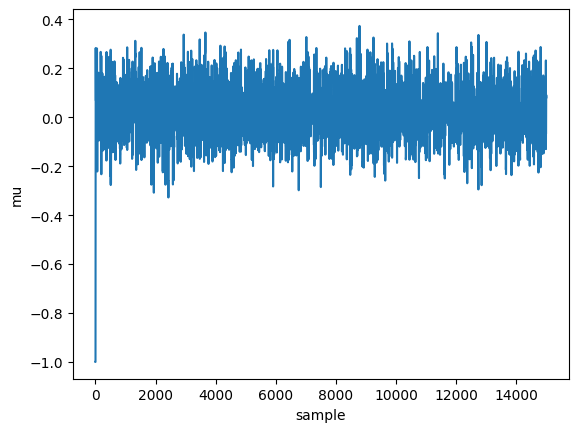

In [6]:
posterior = sampler(data, samples=15000, mu_init=-1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

What's happening at the beginning? That depends on our initial proposal, which is bad. One always needs to remove some samples at the beginning. This is called **"burn in"**.

Making a histogram of these results is our estimated posterior probability distribution. Let's remove the first $500$ points as burn-in.

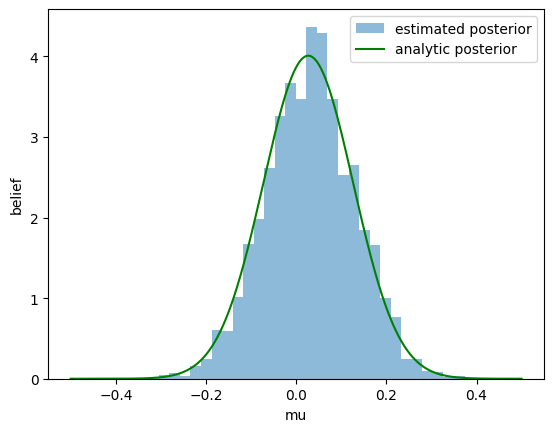

In [7]:
ax = plt.subplot()

burn = 500
ax.hist(posterior[burn:], bins=30, alpha=0.5,
        density='True', label='estimated posterior')

xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');

ax.legend(fontsize=10);

We can compute the expected value of $\mu$, credible regions, and the MAP value.

In [8]:
# expected value
ex_mu = np.mean(posterior[burn:])

# 68% equal-tailed credible region
lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)

# MAP value
# many samplers output the likelihood x prior,
# so it's usually than this
hist, bins = np.histogram(posterior[burn:], bins=30)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('Expected value of mu = ' + str(ex_mu))
print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('MAP value = ' + str(map_theta))

Expected value of mu = 0.031654096125402834
68% credible region = -0.06622887192725768 to 0.13205416681847315
MAP value = 0.03442424988343207


Our algorithm for deciding where to move next used a normal distribution where the mean was the current value and we assumed a width of 0.5. Let's make this much smaller and much larger and see what it does to the sampling efficiency through the behavior of the traceplot.

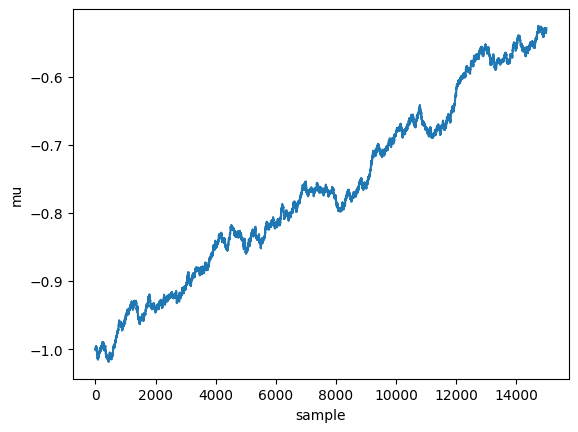

In [9]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.001)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

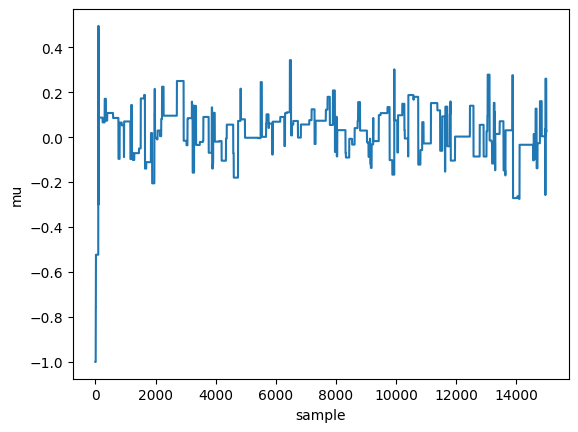

In [10]:
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=10)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Ideally, our traceplot in each parameter would be **mixing well** (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. **The acceptance rate of new samples should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve**.

Take a look at these plots below for an arbitrary problem. The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples.

- **In the top row, the proposal width was too small**. The chain hardly moves, giving it a high acceptance rate but poor global exploration of the posterior surface.
- **In the middle row, the proposal width was too big**. The chain proposes new points that are far away from regions of high probability density, meaning that they're hardly ever accepted. The chain gets stuck.
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**

![](attachment:fig_taylor_mcmc.png)

---

## Very important

Note that MCMC does not give you the value of the pdf on a grid: **all you have are the samples!**

Crucially, the **density** of samples is proportional to the posterior. So running a density estimation tool (histogram, KDE, etc) on those returns the  pdf you're looking for.

---

### See it live

- The example you worked through above was overkill in that we were only trying to estmate $\mu$. Note also that we can do this in fewer than 10 lines using something like ${\tt emcee}$ or ${\tt pymc3}$ (next time!).

- The process is essentially the same when you add more parameters. Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.

- Also, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=AdaptiveMH&target=multimodal) amazing visualization tool, and have some fun exploring the many different types of sampling algorithms. Metropolis-Hastings is only the start!

- In fact, the most basic type of MH algorithm I would ever personally use is **Adaptive Metropolis-Hastings**, where the proposal width updates itself in response to the currently-estimate covariance matrix of the MCMC chain (i.e. the chain learns how to optimize itself).

- In practice, MH is too simple for current problems. There are plenty of tools that a professional astrophysicist can have in their toolbox to tackle research problems.

# Practical MCMC <a class="anchor" id="one"></a>

Make sure the python package `emcee` is installed.

In [13]:
pip install astroML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 1.4 MB/s eta 0:00:00


In [15]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

### Practical MCMC chain checks

1. **CHECK ACCEPTANCE:** some MCMC samplers give an updating estimate of the current acceptance rate of new samples. Ideally for a sampler using some form of Metropolis-Hastings, this should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve.

    - If the acceptance rate is high, the chain is moving but might not be exploring well. This gives high acceptance rate but poor global exploration of the posterior surface.
    
    - If the acceptance rate is low, the chain is hardly moving meaning that it's stuck in a rut or trying to jump to new points that are too far away.
    

2. **CHECK TRACEPLOTS:** After getting an idea of the acceptance rate, make traceplots of your chain. Ideally, our traceplot in each parameter would be mixing well (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. This will tell you whether your chain is getting stuck or encountering inefficiencies.


3. **CHECK AUTOCORRELATION LENGTH:** The MCMC chain with Metropolis-Hastings will not give fully-independent random samples. The next point is influenced by where the previous point was. We need to check how much to down-sample the chain so that the points lack memory and influence from others. This is given by the ***autocorrelation length***. The operation of selecting samples every other autocorrleation lenght is called ***thinning***.

Check this out: [Roy (2019)](https://arxiv.org/abs/1909.11827)

For a discussion on the mathematical definition of the autocorrelation, I find the [emcee documentation](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) particularly clear. It is a concise version of [this paper](https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225?p2df).

![Screen%20Shot%202022-03-25%20at%2017.41.00.png](attachment:Screen%20Shot%202022-03-25%20at%2017.41.00.png)

### Optimizing sampling

There are several ways of improving the way we propose new sample locations in Metropolis-Hastings. Here are a few. They are described in the textbook, or really just google these names.

#### (a) Adaptive Metropolis (AM)

In AM you use the **empirically-estimated parameter covariance matrix to tune the width of the Gaussian proposal  distribution**. Tuning is updated during the sampling in order to reach optimal mixing. In practice this  means  that  one  uses  the  entire  past  history  of  the  chain  up  until  the  current point to estimate the parameter covariance matrix, scaling this covariance matrix by $\alpha= 2.38^2/N_\mathrm{param}$ to reach the optimal $\sim25\%$ proposal acceptance rate.

Practically speaking, the procedure is
- Estimate the $N_\mathrm{param}\times N_\mathrm{param}$ parameter covariance matrix, $C$, using all samples. Standard numpy or scipy algorithms can do this.
- Factorize the matrix using a Cholesky algorithm, such that $C = L L^T$.
- Draw a new proposed point such that $y = x_i + \alpha Lu$, where $x_i$ is the current point, and $u$ is an $N_\mathrm{param}$-dimensional vector of random draws from a zero-mean unit-variance Gaussian.

*One subtlety here is that by using more than just the most recent point to tune the sampling, our chain is no longer Markovian. This is easily resolved by allowing the chain to pass through a proposal tuning stage using AM, after which the proposal covariance matrix is frozen so that the chain is Markovian then on.*

#### (b) Single Component Adaptive Metropolis (SCAM)

With high-dimensional model parameter spaces, or even target posterior distributions with significant covariances amongst some parameters, the AM method may suffer from low acceptance rates. One method that addresses this is a variant on AM called Single Component Adaptive Metropolis (SCAM).  **This  involves  jumping  along selected eigenvectors (or principal axes) of the parameter covariance matrix**, which is equivalent to jumping in only one uncorrelated parameter at a time. (We'll see more of principal axes later in the course)

- We take our parameter covariance matrix as in AM, but this time work out the eigenvalues and eigenvectors, $C = D\Lambda D^T$, where $D$ is a unitary matrix with eigenvectors as columns, and $\Lambda = \mathrm{diag}(\sigma^2_\Lambda$) is a diagonal matrix of eigenvalues.
- A SCAM jump corresponds to a zero-mean unit-variance jump in a randomly chosen uncorrelated parameter, equivalent to jumping along one of the eigenvectors.
- A proposal draw is given by $y = x_i+ 2.4 D_j u_j$, where $D_j$ is a randomly chosen column of D corresponding to the $j$th eigenvector of $C$, and $u_j \sim \mathcal{N}(0,\sigma^j_\Lambda)$.

#### (c) Differential Evolution (DE)

Another popular proposal scheme is DE, which is a simple *genetic algorithm* that treats the past history of the  chain up until the current point as a population.

- In DE, you choose two random points from the chain’s history to construct a difference vector along which the chain can jump.
- A DE proposal draw is given by $y = x_i + \beta(x_{r1} − x_{r2})$, where $x_{r1,2}$ are parameter vectors from two randomly chosen points in the past history of the chain, and $\beta$ is a scaling factor that is usually set to be the same as the AM scaling factor, $\alpha = 2.4^2 / N_\mathrm{param}$.

#### (d) Hamiltonian Monte Carlo (HMC)

These relies on treaing the jumps as physical particles, subject to the Hamilton equations, more [here](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo). Crucially, one needs to know the derivative of the likelihood, and not just the likelihood itself. Sometime this can be hard/expensive to compute


#### The Full Proposal Cocktail

Real world MCMC should use a cocktail of proposal schemes, aimed at ensuring convergence to the target posterior distribution with **minimal burn-in**, **optimal acceptance rate**, and as **short an autocorrelation length** as possible.

At each MCMC iteration the proposed parameter location can be drawn according to a weighted list of schemes, involving **(i) AM, (ii) SCAM, (iii) DE, (iv) empirical proposal distributions (e.g. from previous analyses), and finally (iv) draws from the parameter prior distribution**.

The final prior-draw scheme allows for occasional large departures from regions of high likelihood, ensuring that we are exploring the full parameter landscape well, and avoiding the possibility of getting stuck in local maxima.

Really, you can use any reasonable distribution you like to propose points. Your only constraint is to ensure that detailed balance is maintained through the relevant transition weightings in  the  Metropolis-Hastings ratio, $p_\mathrm{acc}$.

##  MCMC Parameter Estimation In The Wild <a class="anchor" id="two"></a>

Let's look at some more involved examples. We will use two popular python modules: `emcee` and `PyMC`. Another  great but less used sampler is `PTMCMCSampler`. Quoting [Jake VanderPlas]((http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)) for `emcee` and `PyMC`:


### emcee

> The emcee package (*also known as MCMC Hammer, which is in the running for best Python package name in history*) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".

Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC

> The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*

More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).

### PTMCMCSampler

> This is a bare-bones sampler, requiring only that the user provide a log-likelihood function and a log-prior function. The user can change the relative amounts of AM, SCAM, and DE being used to propose new points to jump to. The great thing about this sampler is that one can add new custom proposal schemes according to the user's preference.

> Also, this sampler implements **parallel tempering MCMC (PTMCMC)**. We won't go into detail about this, but suffice it to say that multiple copies of the MCMC are run in parallel, where the copies actually sample from different roots of the likelihood. The higher roots we take, the more the likelihood is flattened out, making it easier to sample. These "rooted" chains then communicate back to the main chain, improving exploration of the parameter space. All these chains can actually be post-processed to get the Bayesian evidence too, in a scheme called **thermodynamic integration**.

##  MCMC with emcee <a class="anchor" id="three"></a>

Import `emcee` and generate some homoscedastic Gaussian data. We'll assume the standard deviation is know, so we're only estimating $\mu$.

In [17]:
pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 825.9 kB/s eta 0:00:00


In [18]:
import emcee
import scipy.stats as stats

np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known
data = stats.norm(mu, sigma).rvs(Ndata)

In [19]:
data

array([ 0.97401788,  0.94440197,  1.5208984 ,  0.37163035,  1.37269384,
        0.14447312,  0.89706781,  0.88271435,  1.56407202,  0.99368702,
        0.69339986,  1.68684425,  1.80549599,  0.65538586,  1.34596186,
        0.7759422 ,  1.08117123,  1.12861457,  0.36227207,  1.03200222,
        0.46907169,  0.5053158 ,  0.77113839,  0.00790919,  0.26177894,
        1.11590148,  1.32207964,  1.42606135,  0.76799064,  1.3485883 ,
        1.78394109,  1.5892781 ,  0.30802157,  0.1263331 ,  1.2013619 ,
        1.6222414 ,  0.98808182,  1.47628385,  1.12248197,  1.11204857,
        1.1483406 ,  1.11037669,  0.78834958,  1.92280756,  1.46005728,
        0.72104189,  0.85738748,  0.47936668,  1.24018471,  0.2863112 ,
        0.83336679,  1.37365425,  1.28011481,  1.28685447,  0.40955974,
        1.38232504,  0.93280751,  1.66231884,  0.86178618,  1.83977549,
        1.20758094,  1.3738408 ,  0.8037348 ,  0.79683796,  0.80707701,
        1.50045109,  0.77615878,  0.94195799,  1.58450731,  1.25

Define all the relevant functions.

In [21]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [22]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens:
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [23]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(6, 100000, 1)
(540000, 1)


In [24]:
emcee_trace.flatten()

array([1.05932246, 1.07194376, 1.10286064, ..., 0.9387902 , 0.9387902 ,
       0.9387902 ])

In [25]:
len(emcee_trace.flatten())

540000

In [26]:
# Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time()
print(tau)
thin = int(tau+1)

[29.6318388]


In [27]:
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()

In [28]:
len(emcee_trace)

18000

Text(0.5, 1.0, 'Chain from emcee')

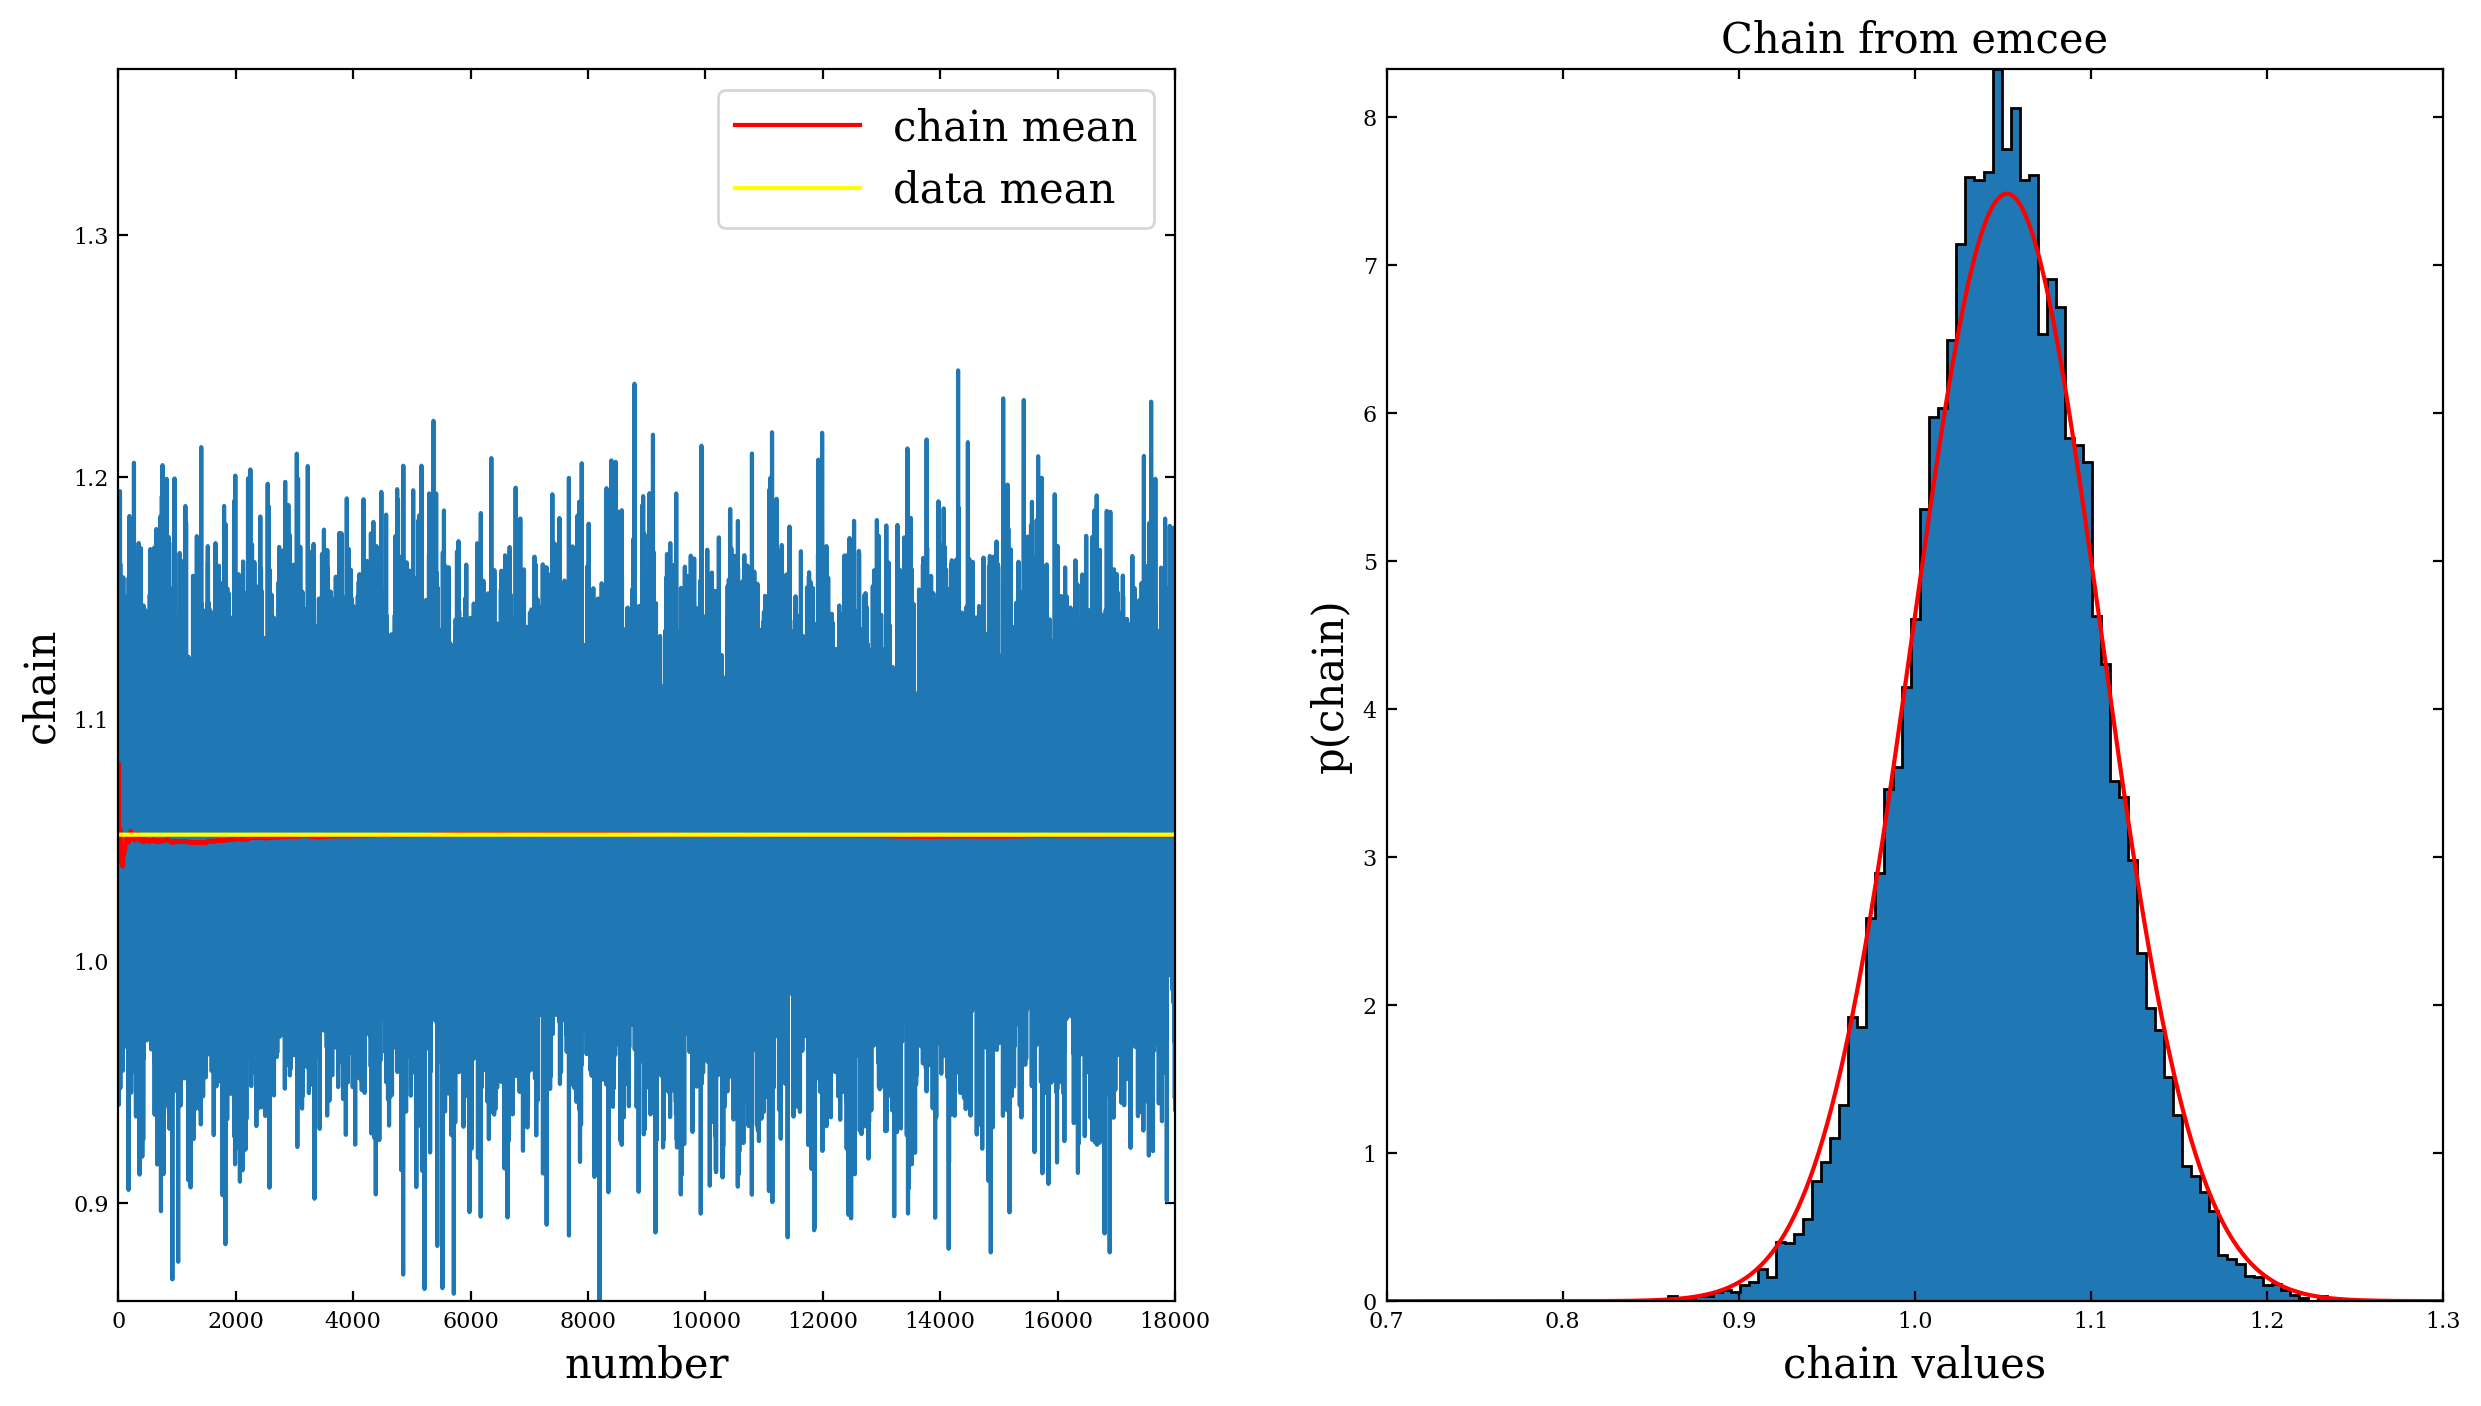

In [35]:
# plot
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(15, 8))
#fig.subplots_adjust(left=0.11, right=0.95,
                   # wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number',fontsize=15)
plt.ylabel('chain',fontsize=15)

# plot running mean:
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean')
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend(fontsize=15)

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
#Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE,
                                bins='auto', histtype='stepfilled',density=True)

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = stats.norm(muCLT, sigCLT).pdf(muGrid)
ax2.plot(muGrid, gauss, c='red')

ax2.set_ylabel('p(chain)',fontsize=15)
ax2.set_xlabel('chain values',fontsize=15)
#ax2.set_xlim(0.7, 1.3)
#ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee',fontsize=15)

##  MCMC with PyMC <a class="anchor" id="four"></a>

I (probably) won't have time to cover this in class, but here it is for future reference.



Now we will use pyMC to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC` and define the Cauchy log likelihood.

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC` has ready-made modules for many standard functions!

In [30]:
from scipy.stats import cauchy
import pymc as pm

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

Generate some data from the Cauchy distribution.

In [31]:
# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

Set up the `PyMC3` model.

In [32]:
# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5) #uniform in Cauchy mu
    log_gamma = pm.Uniform('log_gamma', -10, 10) #uniform in log of Cauchy gamma

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Cauchy variable'
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

You may have seen some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job.

In this case, it decided you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space.

In [33]:
mu = np.array(trace['posterior']['mu']).flatten()
loggamma = np.array(trace['posterior']['log_gamma']).flatten()


# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(mu,
                                             np.exp(loggamma),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(mu, bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(loggamma),
                                      bins=gamma_bins, density=True)

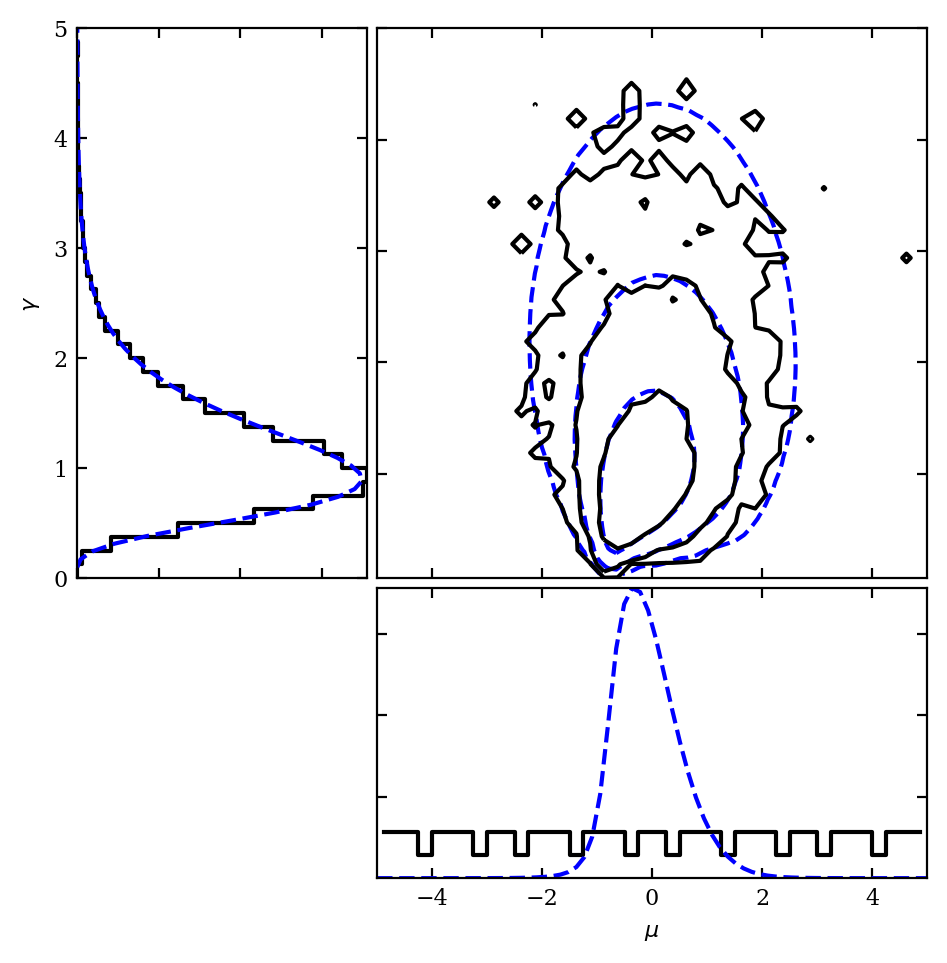

In [34]:
# ----------------------------------------------------------------------
# plot all the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

# Exam exercise!

## Time transients

Time transients appear in many many physical applications. Electromagnetic signals, electronics readouts, or in astronomy things like exploding stars, gravitational waves, etc etc etc.

An instrument (say a microphone) is taking data and there's some background noise. Then at some point a signal appears. The features of the signals contain precious information (which rock band is playing, the details of the exploding star).


(Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!)


### Tasks

1) Read in `datasets/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the intensity of the signal (arbitrary units), and the third column are measurement uncertainties on the latter. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code up this burst model, and code a likelihood function for this data with the burst model.

3) Using one of the MCMC sampler that we looked at in class, perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$

8) Another possible model that may explain the data is a Gaussian profile.

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

 Fit this model usign an MCMC and reasonable priors (this time is up to you to decide...)

9) Now.. is that transient an exponential pulse or a gaussian? What do you think? We need to quantify it... and that's going to be the goal of the next two lectures! So stay tuned.



### Results...

This exercise was much harder than the previous ones (yep, I know), so here is the result so you can check what you have makes sense. This is not a unique answer! If you made different choices that's ok.  

This is my stationary chain (the trace plot)...

![download-2.png](attachment:download-2.png)

... and this is my corner plot

![download-1.png](attachment:download-1.png)

In [37]:
pip install corner

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from IPython.display import display, Markdown

# Load the dataset
data = np.load('/content/transient.npy')




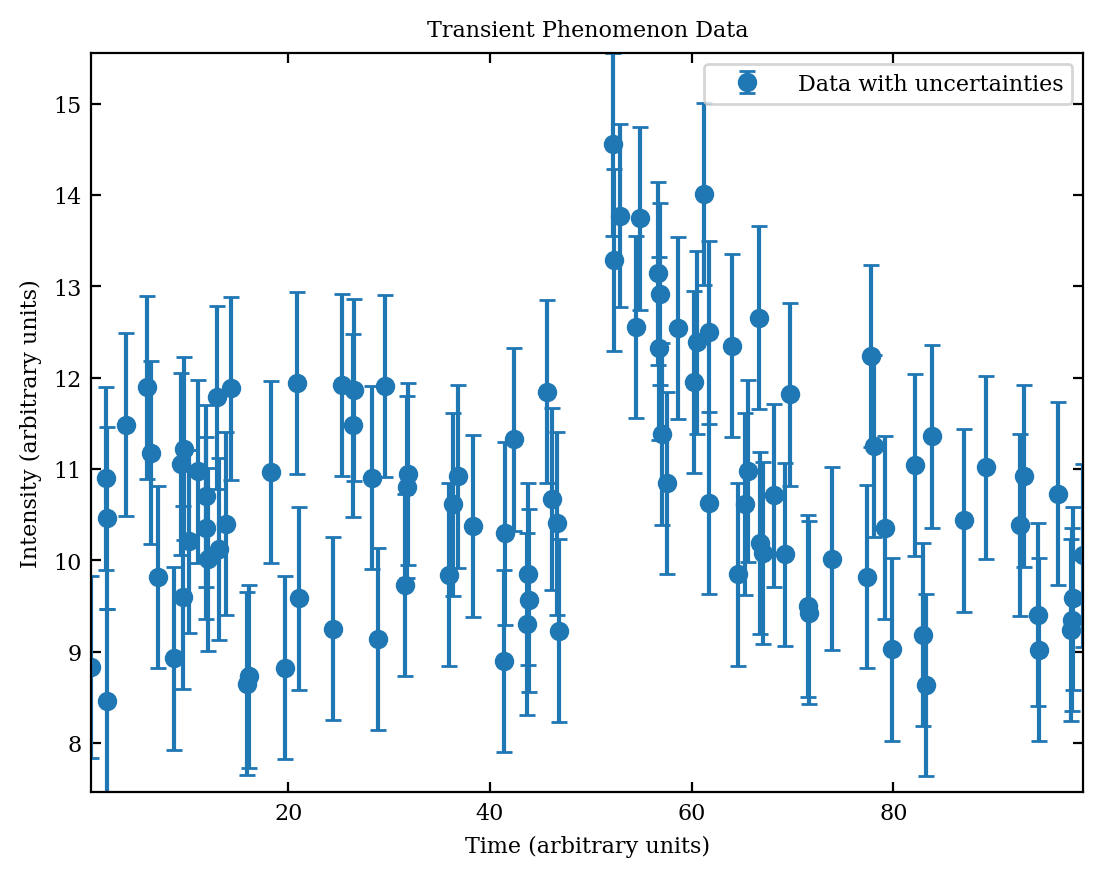

In [40]:
# Extract columns
time = data[:, 0]
intensity = data[:, 1]
uncertainty = data[:, 2]

# Plot the data with uncertainties
plt.errorbar(time, intensity, yerr=uncertainty, fmt='o', label='Data with uncertainties')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Transient Phenomenon Data')
plt.legend()
plt.show()




In [41]:
# Burst model function
def burst_model(t, b, A, t0, alpha):
    y = np.zeros_like(t)
    y[t < t0] = b
    y[t >= t0] = b + A * np.exp(-alpha * (t[t >= t0] - t0))
    return y

# Likelihood function for burst model
def log_likelihood_burst(theta, t, y, yerr):
    b, A, t0, alpha = theta
    model = burst_model(t, b, A, t0, alpha)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Define priors
def log_prior_burst(theta):
    b, A, t0, alpha = theta
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < np.log(alpha) < 5:
        return 0.0
    return -np.inf

# Combined log-probability
def log_probability_burst(theta, t, y, yerr):
    lp = log_prior_burst(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_burst(theta, t, y, yerr)

# Initial guess for the parameters
initial_burst = np.array([10, 20, 50, 0.1])
ndim, nwalkers = 4, 32
pos_burst = initial_burst + 1e-4 * np.random.randn(nwalkers, ndim)


100%|██████████| 5000/5000 [00:18<00:00, 265.95it/s]


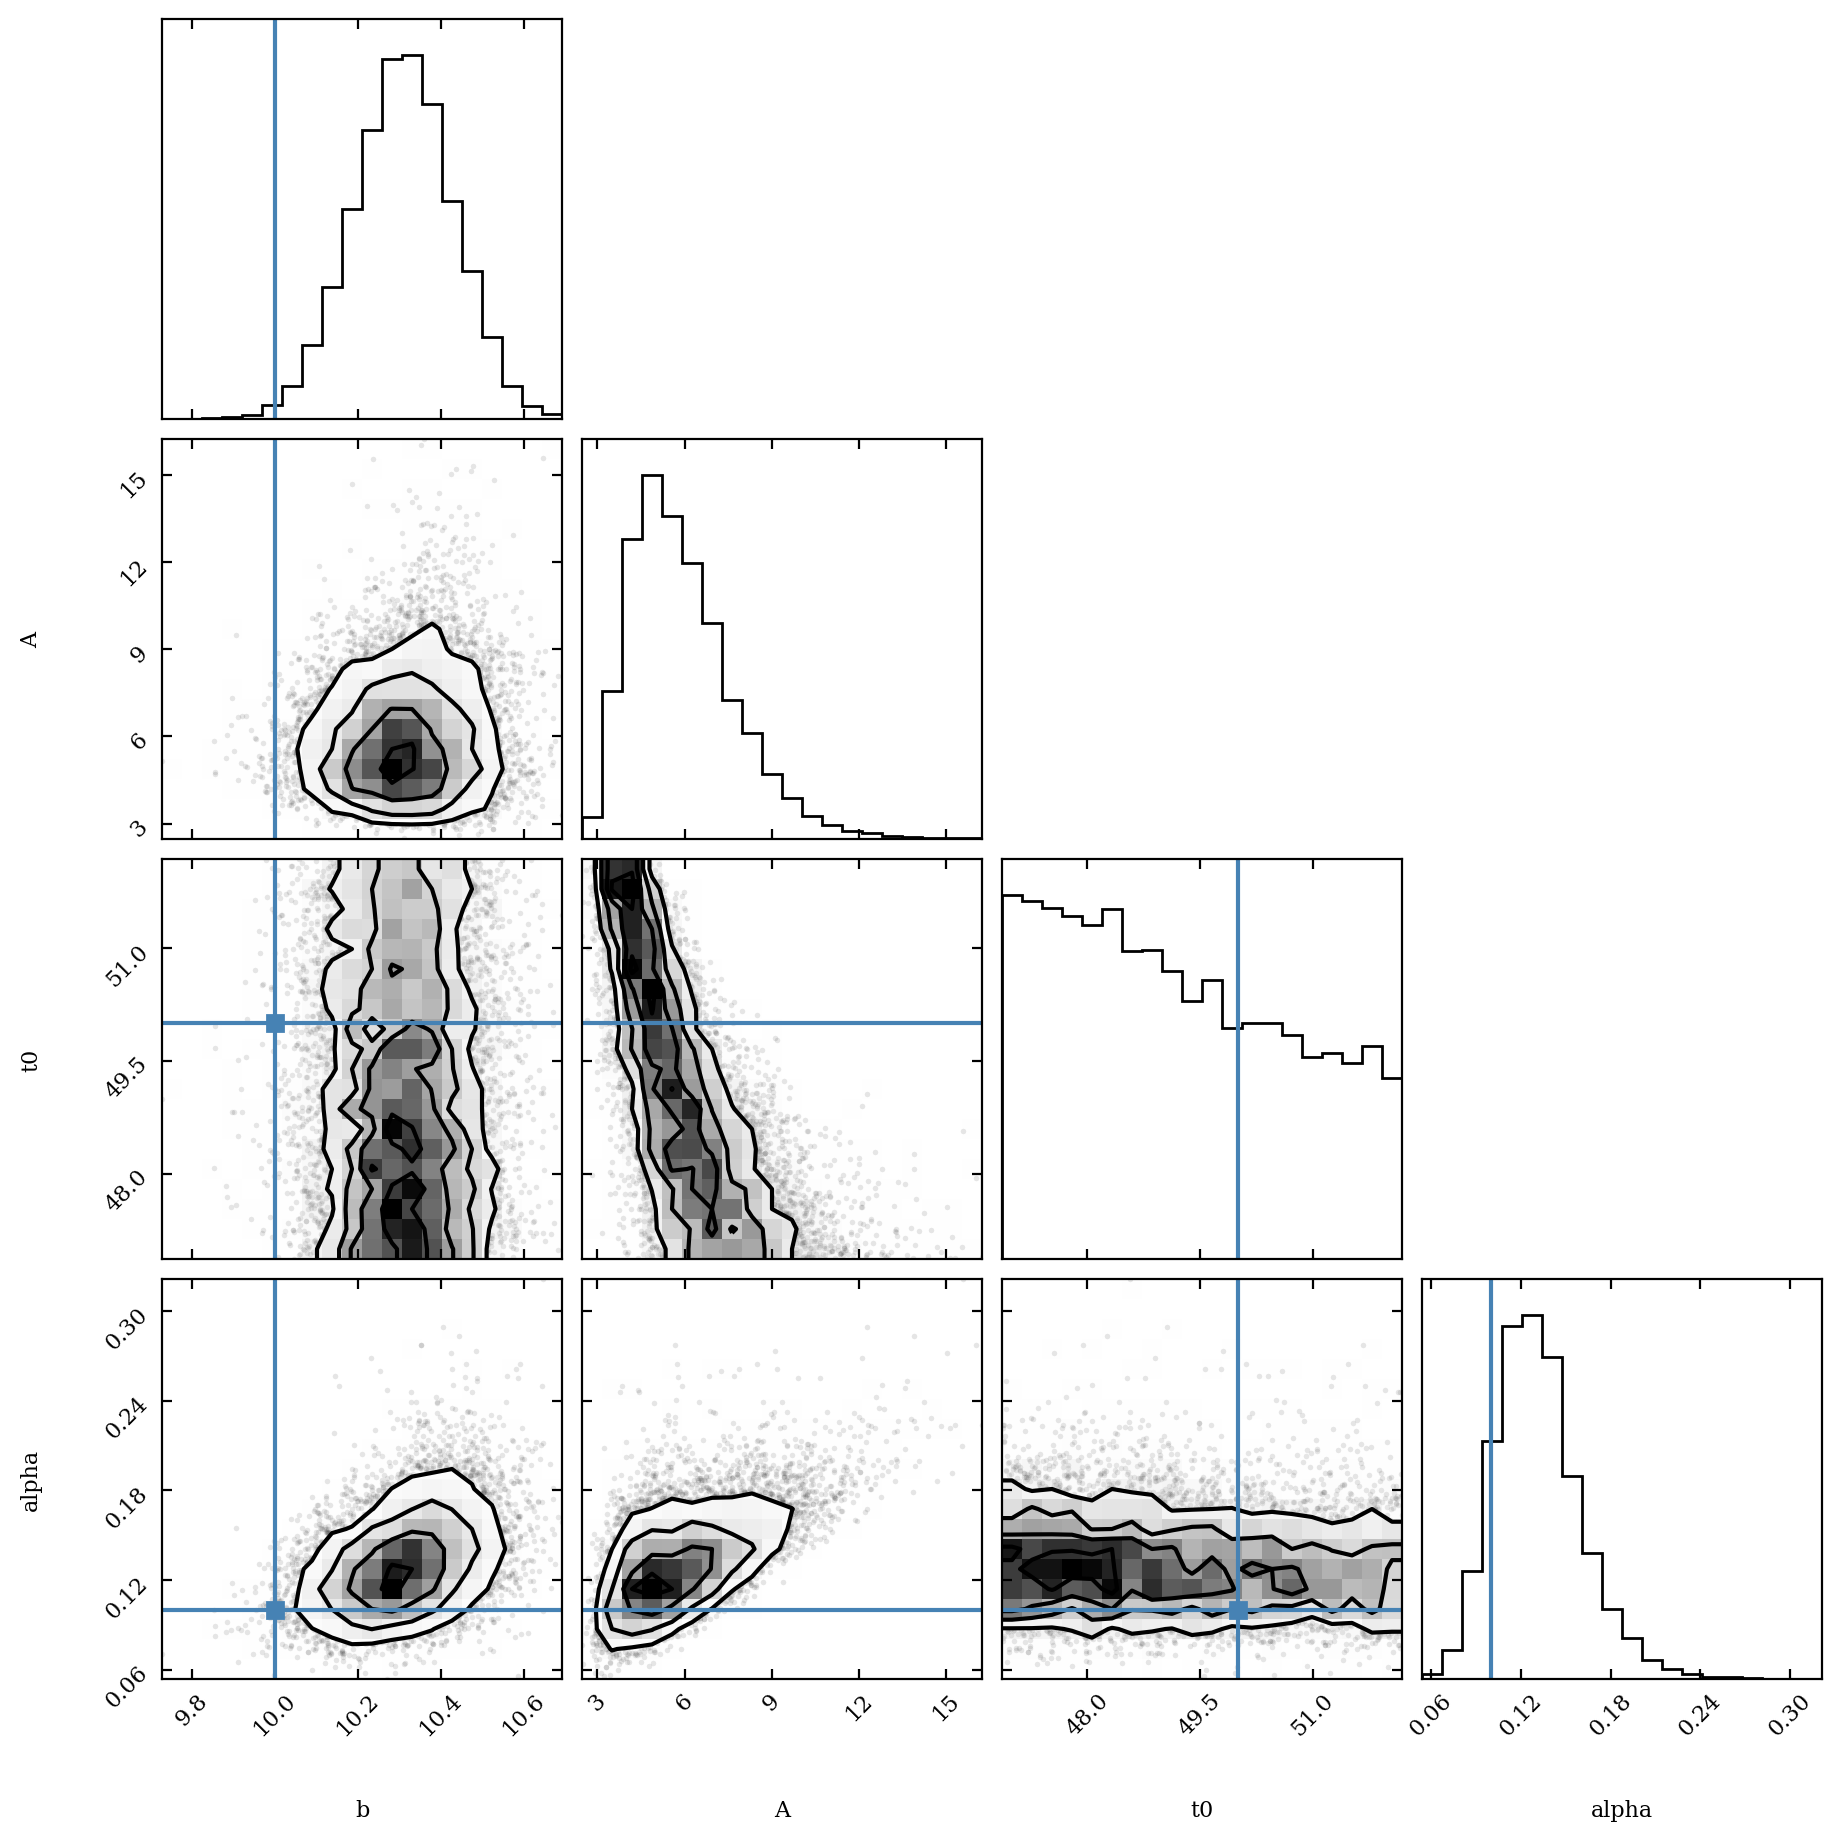

In [42]:
# Set up the MCMC sampler for burst model
sampler_burst = emcee.EnsembleSampler(nwalkers, ndim, log_probability_burst, args=(time, intensity, uncertainty))
sampler_burst.run_mcmc(pos_burst, 5000, progress=True)

# Flatten the chain and discard burn-in points
flat_samples_burst = sampler_burst.get_chain(discard=1000, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(flat_samples_burst, labels=["b", "A", "t0", "alpha"], truths=[10, 20, 50, 0.1])
plt.show()




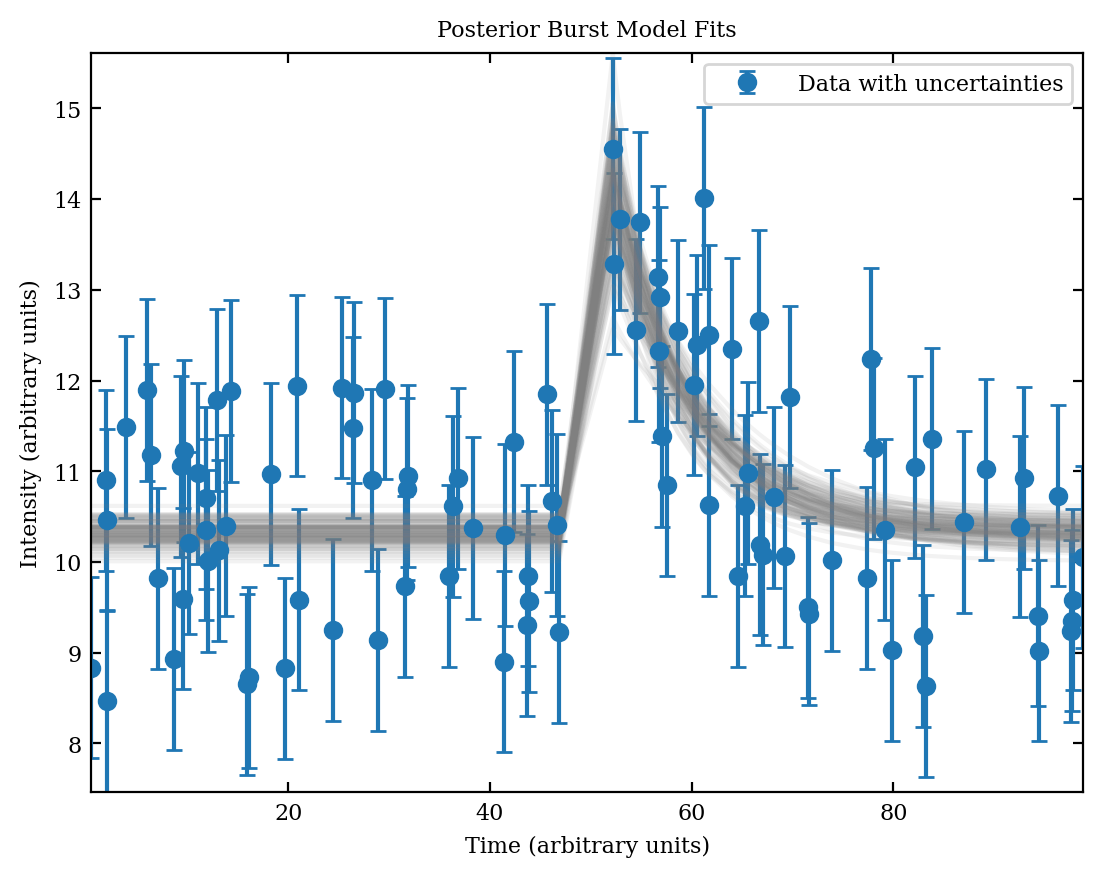

**b** = 10.311 (+0.195, -0.203)

**A** = 5.614 (+3.712, -1.976)

**t0** = 49.010 (+2.782, -1.953)

**alpha** = 0.129 (+0.056, -0.039)

In [43]:
# Plot 100 random samples from the posterior
plt.errorbar(time, intensity, yerr=uncertainty, fmt='o', label='Data with uncertainties')

for s in flat_samples_burst[np.random.randint(len(flat_samples_burst), size=100)]:
    plt.plot(time, burst_model(time, *s), color="gray", alpha=0.1)

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Posterior Burst Model Fits')
plt.legend()
plt.show()

# Find median and 90% credible regions for each parameter
medians_burst = np.percentile(flat_samples_burst, 50, axis=0)
cred_intervals_burst = np.percentile(flat_samples_burst, [5, 95], axis=0)

parameters_burst = ["b", "A", "t0", "alpha"]
for i, param in enumerate(parameters_burst):
    display(Markdown(f"**{param}** = {medians_burst[i]:.3f} (+{cred_intervals_burst[1][i] - medians_burst[i]:.3f}, -{medians_burst[i] - cred_intervals_burst[0][i]:.3f})"))



In [44]:
# Gaussian model function
def gaussian_model(t, b, A, t0, sigma):
    return b + A * np.exp(-0.5 * ((t - t0) / sigma) ** 2)

# Likelihood function for Gaussian model
def log_likelihood_gaussian(theta, t, y, yerr):
    b, A, t0, sigma = theta
    model = gaussian_model(t, b, A, t0, sigma)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Define priors for Gaussian model
def log_prior_gaussian(theta):
    b, A, t0, sigma = theta
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and 0 < sigma < 20:
        return 0.0
    return -np.inf

# Combined log-probability for Gaussian model
def log_probability_gaussian(theta, t, y, yerr):
    lp = log_prior_gaussian(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian(theta, t, y, yerr)



100%|██████████| 5000/5000 [00:11<00:00, 450.61it/s]


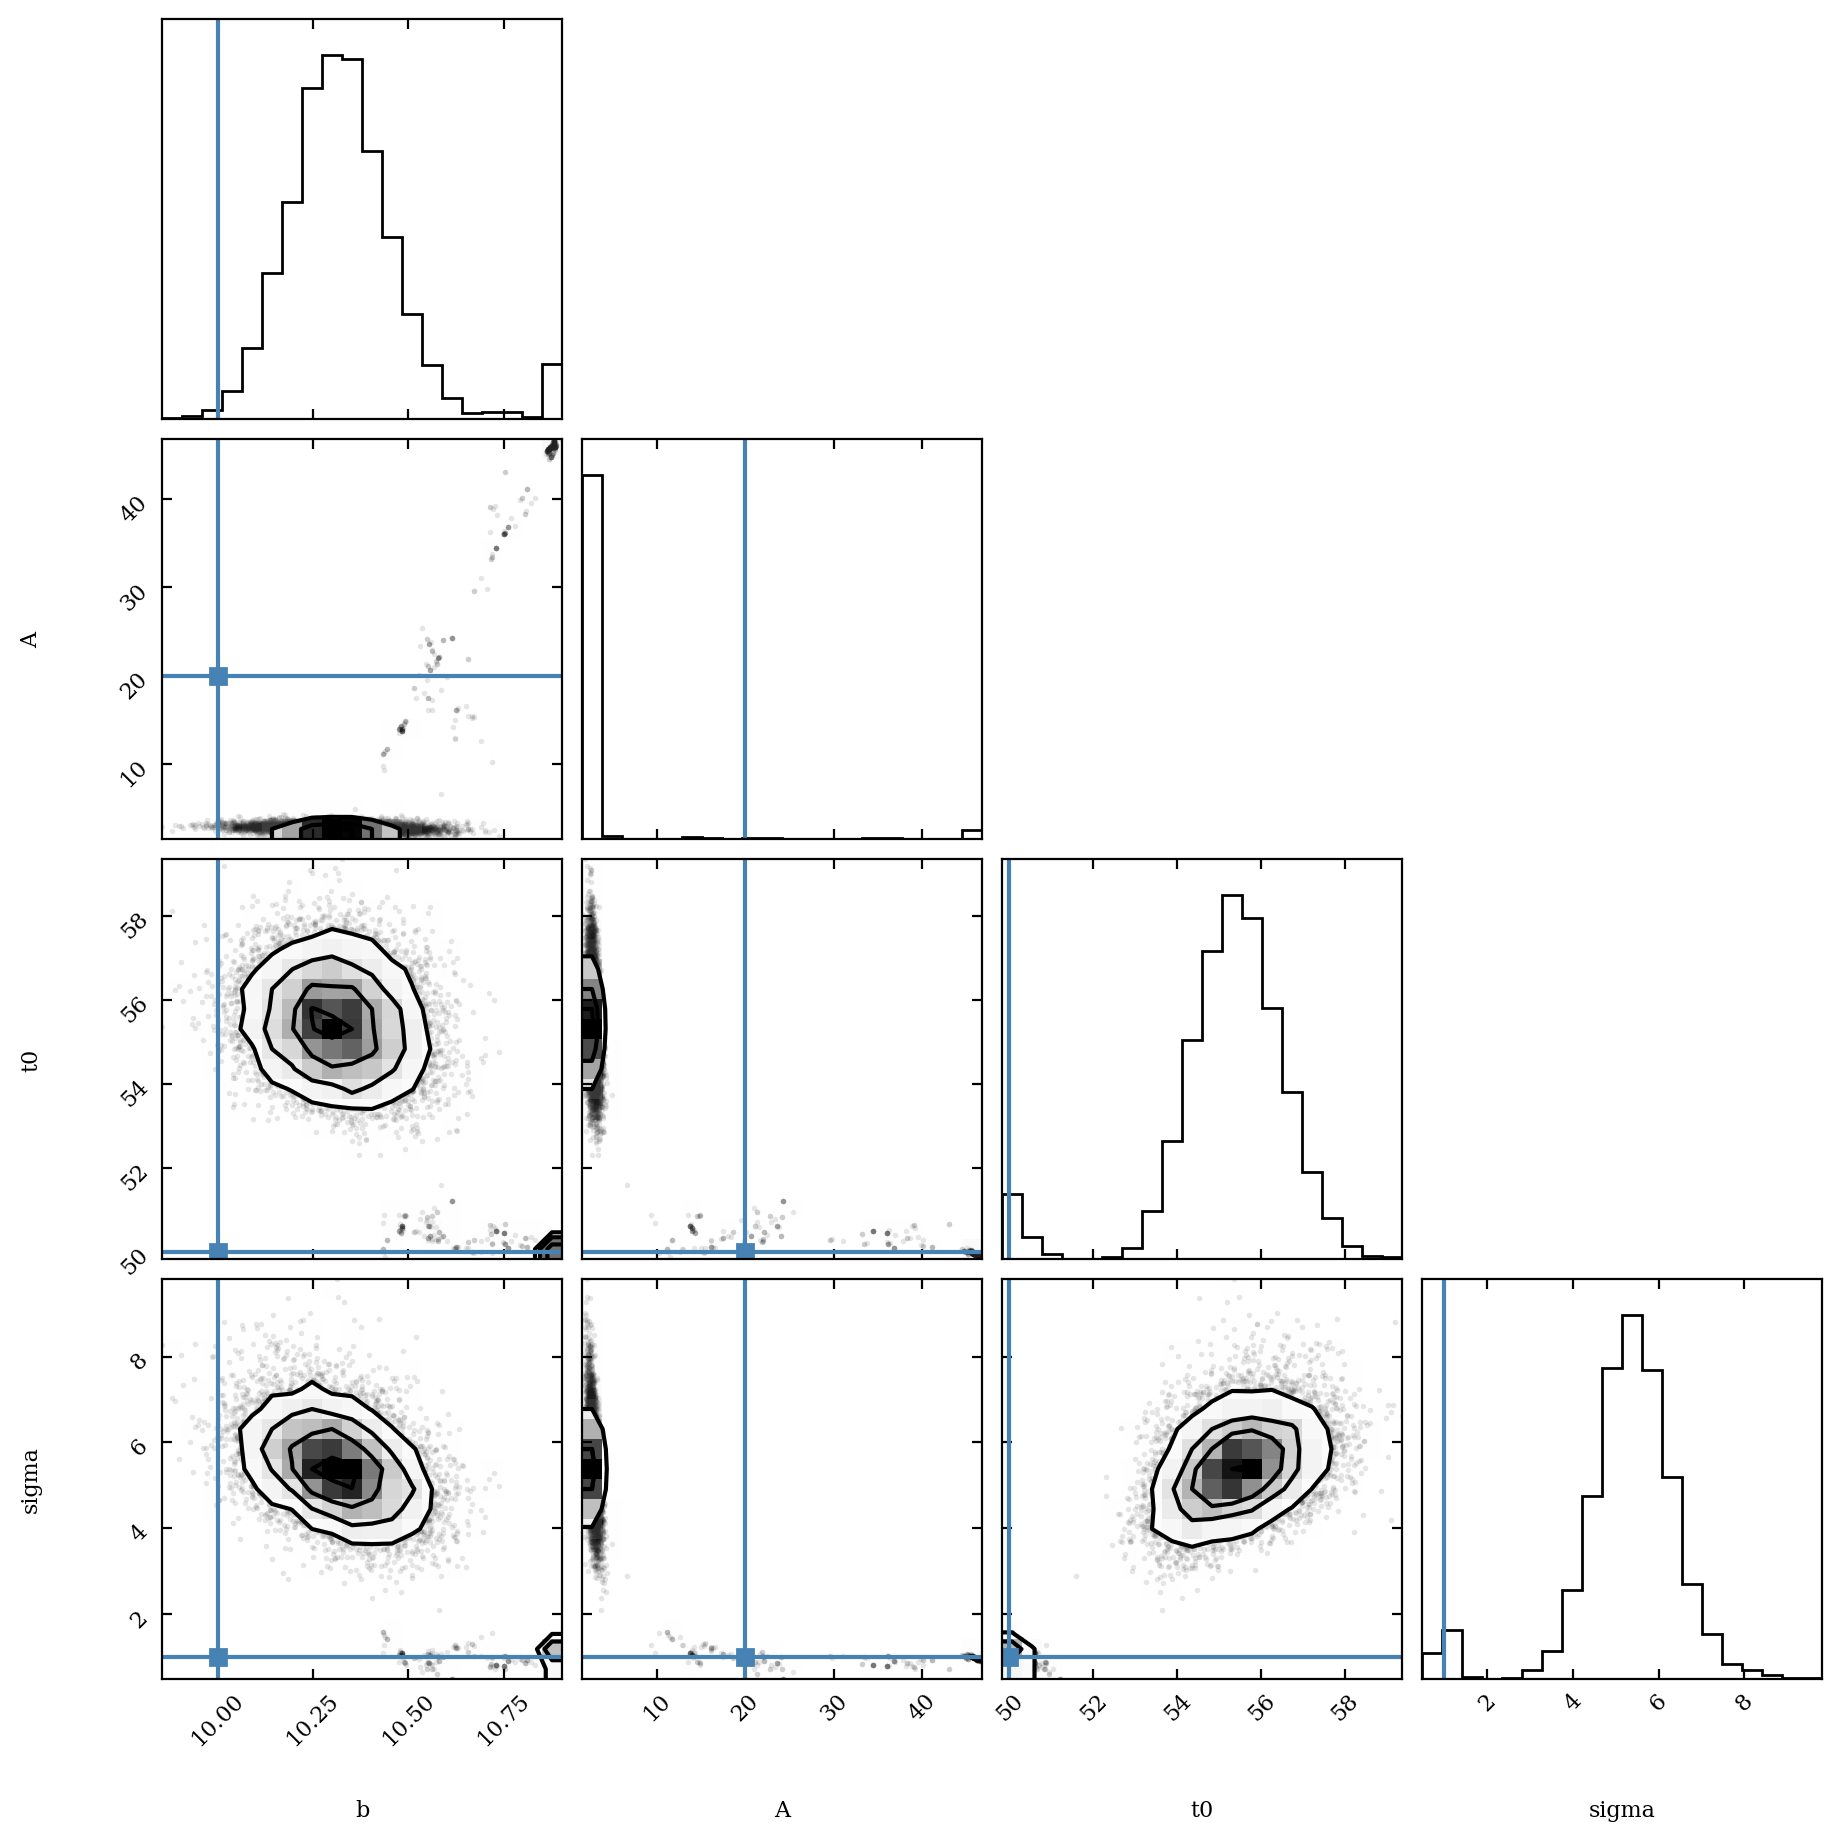

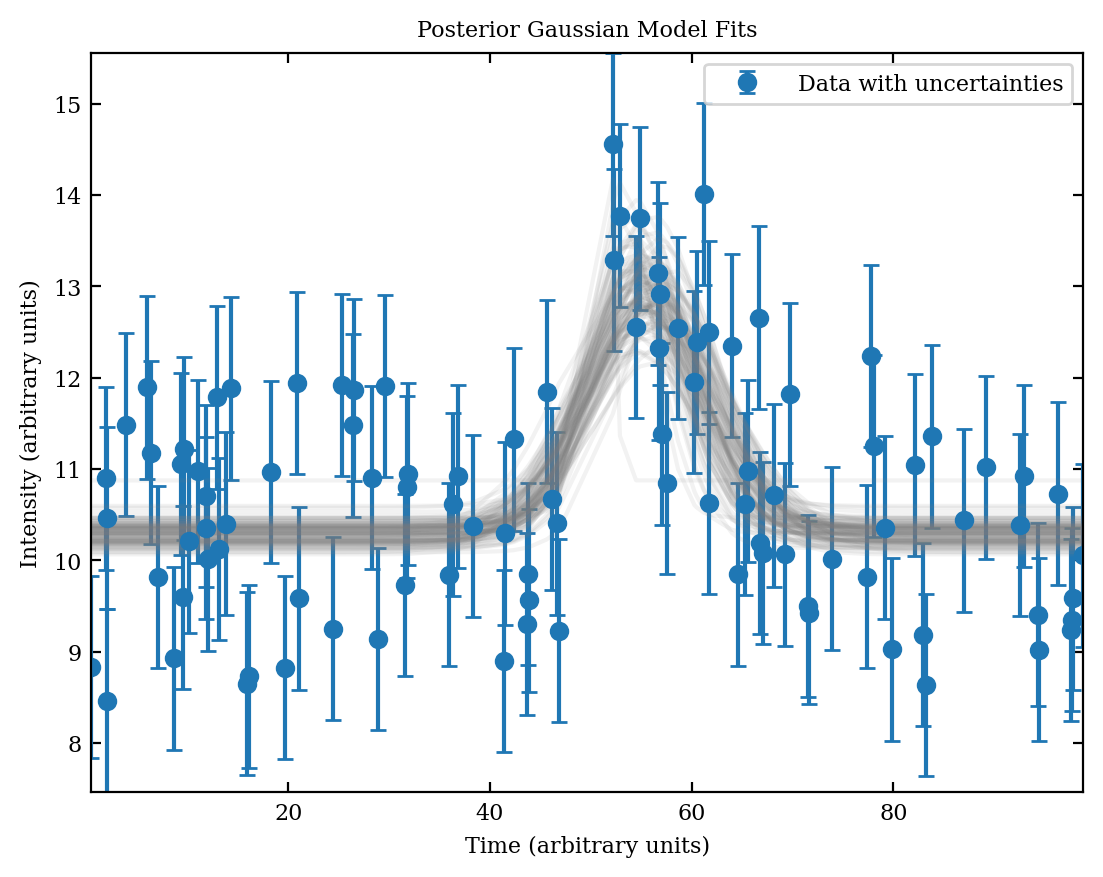

**b** = 10.318 (+0.251, -0.202)

**A** = 2.734 (+1.060, -0.609)

**t0** = 55.365 (+1.780, -2.240)

**sigma** = 5.374 (+1.552, -2.113)

In [45]:
# Initial guess for the parameters
initial_gaussian = np.array([10, 20, 50, 1])
ndim, nwalkers = 4, 32
pos_gaussian = initial_gaussian + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler for Gaussian model
sampler_gaussian = emcee.EnsembleSampler(nwalkers, ndim, log_probability_gaussian, args=(time, intensity, uncertainty))
sampler_gaussian.run_mcmc(pos_gaussian, 5000, progress=True)

# Flatten the chain and discard burn-in points
flat_samples_gaussian = sampler_gaussian.get_chain(discard=1000, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(flat_samples_gaussian, labels=["b", "A", "t0", "sigma"], truths=[10, 20, 50, 1])
plt.show()

# Plot 100 random samples from the posterior
plt.errorbar(time, intensity, yerr=uncertainty, fmt='o', label='Data with uncertainties')

for s in flat_samples_gaussian[np.random.randint(len(flat_samples_gaussian), size=100)]:
    plt.plot(time, gaussian_model(time, *s), color="gray", alpha=0.1)

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Intensity (arbitrary units)')
plt.title('Posterior Gaussian Model Fits')
plt.legend()
plt.show()

# Find median and 90% credible regions for each parameter
medians_gaussian = np.percentile(flat_samples_gaussian, 50, axis=0)
cred_intervals_gaussian = np.percentile(flat_samples_gaussian, [5, 95], axis=0)

parameters_gaussian = ["b", "A", "t0", "sigma"]
for i, param in enumerate(parameters_gaussian):
    display(Markdown(f"**{param}** = {medians_gaussian[i]:.3f} (+{cred_intervals_gaussian[1][i] - medians_gaussian[i]:.3f}, -{medians_gaussian[i] - cred_intervals_gaussian[0][i]:.3f})"))



In [46]:
# Compare the models using Bayesian Information Criterion (BIC)
def BIC(log_likelihood, k, n):
    return -2 * log_likelihood + k * np.log(n)

# Calculate the maximum log likelihood for both models
max_log_likelihood_burst = np.max(sampler_burst.get_log_prob())
max_log_likelihood_gaussian = np.max(sampler_gaussian.get_log_prob())

# Number of data points
n = len(time)

# Number of parameters for each model
k_burst = 4
k_gaussian = 4

# Calculate BIC for both models
BIC_burst = BIC(max_log_likelihood_burst, k_burst, n)
BIC_gaussian = BIC(max_log_likelihood_gaussian, k_gaussian, n)

display(Markdown(f"**BIC for Burst Model:** {BIC_burst:.2f}"))
display(Markdown(f"**BIC for Gaussian Model:** {BIC_gaussian:.2f}"))

# Determine which model is better
if BIC_burst < BIC_gaussian:
    display(Markdown("The transient is better explained by the **Burst Model**."))
else:
    display(Markdown("The transient is better explained by the **Gaussian Model**."))



**BIC for Burst Model:** 115.93

**BIC for Gaussian Model:** 123.24

The transient is better explained by the **Burst Model**.